# Layer Sensitivity Analysis

**Objective:**
Quantizing an entire neural network to 4-bit (INT4) often destroys accuracy. However, not all layers are equally important. This module implements a **Sensitivity Scanner** to identify which layers are "Divas" (fragile) and which are "Stoics" (robust).

**The Strategy:**
We perform a "perturbation test" on the model:
1.  **Iterate** through every layer in the model.
2.  **Quantize** *only* that specific layer to INT4, keeping the rest of the model at FP32.
3.  **Measure** the damage (Drift) using KL Divergence compared to the baseline.
4.  **Policy:** Construct a Mixed-Precision configuration that keeps fragile layers at INT8 and compresses robust layers to INT4.

**What to Expect (The "Diva" Pattern):**
While exact drift values will vary slightly due to the random calibration data, you should consistently observe three phenomena:
1.  **The Early Spike:** The first convolutional layers are often highly sensitive; corrupting raw features cascades errors through the whole network.
2.  **The Downsample Trap:** The 1x1 convolutions in Residual Shortcuts (e.g., `layerX.0.downsample.0`) are structural bottlenecks and usually show massive drift.
3.  **The Green Valley:** The majority of the deep 3x3 convolutions are incredibly robust and can be safely crushed to INT4.

**Outcome:**
We expect to generate a policy that compresses the model to **~15% of its original size** (vs 25% for standard INT8) by proving that most layers do not need high precision.

In [1]:
# @title Setup & Calibration Data
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Load a standard backbone (ResNet18)
# We use this because it has a mix of 3x3 Convs, 1x1 Convs, and Downsampling layers
# which usually show distinct sensitivity patterns.
print("Loading ResNet18...")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
model.eval()

# Calibration Set
# In a real scenario, we'd grab a batch from the Val DataLoader.
# For this demo, we use synthetic data to ensure the code runs immediately without downloading ImageNet.
print("Generating Calibration Batch (N=128)...")
calibration_data = torch.randn(128, 3, 224, 224).to(device)

# Get "Golden" (FP32) Logits for baseline comparison
with torch.no_grad():
    golden_logits = model(calibration_data)
    golden_probs = F.softmax(golden_logits, dim=1)

print("Baseline established.")

Running on: cuda
Loading ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Generating Calibration Batch (N=128)...
Baseline established.


In [2]:
# @title Quantization Simulator (INT4)
def fake_quantize_tensor(tensor, num_bits=4):
    """
    Simulates quantization noise on a weight tensor.
    Formula: Q = round(x / scale) * scale
    """
    if num_bits >= 32:
        return tensor.clone()

    # Calculate Dynamic Range
    qmin = -(2**(num_bits - 1))
    qmax = (2**(num_bits - 1)) - 1
    min_val, max_val = tensor.min(), tensor.max()

    # Avoid div-by-zero if weight is all zeros (unlikely but possible in pruning)
    if min_val == max_val:
        return tensor.clone()

    # Determine Scale
    scale = (max_val - min_val) / (qmax - qmin)
    zero_point = qmin - min_val / scale

    # Simulate the hardware rounding
    q_tensor = (tensor / scale + zero_point).round().clamp(qmin, qmax)
    dq_tensor = (q_tensor - zero_point) * scale

    return dq_tensor

# Sanity Check (Always test your tools!)
print("--- Simulator Sanity Check ---")
dummy = torch.tensor([-0.5, 0.0, 0.5, 1.2])
q_dummy = fake_quantize_tensor(dummy, num_bits=4)
print(f"Input:    {dummy.numpy()}")
print(f"INT4 Sim: {q_dummy.numpy()}")
print("Drift seems reasonable.")

--- Simulator Sanity Check ---
Input:    [-0.5  0.   0.5  1.2]
INT4 Sim: [-0.5        -0.04666666  0.52000004  1.2       ]
Drift seems reasonable.


In [3]:
# @title Metric: KL Divergence
def compute_kl_divergence(probs_p, probs_q):
    """
    Calculates the Kullback-Leibler Divergence between two distributions.
    P: Golden (Target)
    Q: Quantized (Approximation)
    """
    # Defensive coding: Add epsilon to prevent log(0) -> NaN
    epsilon = 1e-8
    probs_p = probs_p + epsilon
    probs_q = probs_q + epsilon

    # KL(P || Q)
    # We sum across classes (dim=1) then mean across batch
    return torch.sum(probs_p * (probs_p / probs_q).log(), dim=1).mean().item()

In [4]:
# @title Run Sensitivity Scan (Layer-by-Layer)
print("Starting Sensitivity Analysis...")
print("Strategy: Quantize ONE layer to INT4, keep others FP32, measure KL Divergence.")

layer_sensitivities = {}
modules_to_scan = []

# Filter for layers with weights
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        modules_to_scan.append((name, module))

print(f"Scanning {len(modules_to_scan)} layers. This may take a minute...")

for i, (name, module) in enumerate(modules_to_scan):
    # 1. Backup original weights
    original_weight = module.weight.data.clone()

    # 2. Attack: Force this layer to INT4
    module.weight.data = fake_quantize_tensor(original_weight, num_bits=4)

    # 3. Measure: Run inference and check drift
    with torch.no_grad():
        perturbed_logits = model(calibration_data)
        perturbed_probs = F.softmax(perturbed_logits, dim=1)

    drift = compute_kl_divergence(golden_probs, perturbed_probs)
    layer_sensitivities[name] = drift

    # 4. Restore: Reset weights for the next iteration
    module.weight.data = original_weight

    # Progress log for the user
    if i % 5 == 0:
        print(f"[{i}/{len(modules_to_scan)}] {name:<30} Drift: {drift:.5f}")

print("Scan Complete.")

Starting Sensitivity Analysis...
Strategy: Quantize ONE layer to INT4, keep others FP32, measure KL Divergence.
Scanning 21 layers. This may take a minute...
[0/21] conv1                          Drift: 0.01629
[5/21] layer2.0.conv1                 Drift: 0.36106
[10/21] layer3.0.conv1                 Drift: 0.82610
[15/21] layer4.0.conv1                 Drift: 0.26496
[20/21] fc                             Drift: 0.03735
Scan Complete.


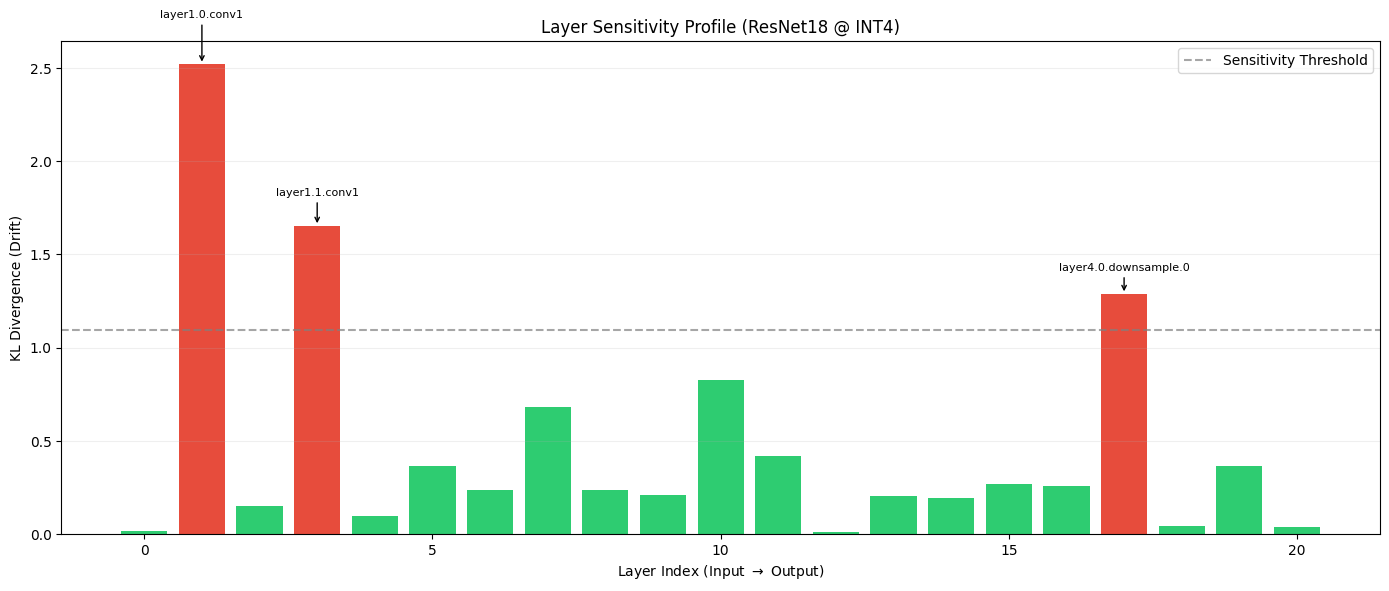

In [5]:
# @title Visualization: The Sensitivity Heatmap
layers = list(layer_sensitivities.keys())
drifts = list(layer_sensitivities.values())

# Dynamic thresholding for the chart
# We define "Sensitive" as anything > 1 standard deviation above the mean
threshold = np.mean(drifts) + np.std(drifts)

colors = ['#2ecc71' if d < threshold else '#e74c3c' for d in drifts]
x = np.arange(len(layers))

plt.figure(figsize=(14, 6))
bars = plt.bar(x, drifts, color=colors)

# Add Threshold Line
plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7, label='Sensitivity Threshold')

# Aesthetics
plt.title('Layer Sensitivity Profile (ResNet18 @ INT4)')
plt.ylabel('KL Divergence (Drift)')
plt.xlabel('Layer Index (Input $\\rightarrow$ Output)')
plt.legend()
plt.grid(axis='y', alpha=0.2)

# Auto-Annotate the "Divas" (Top 3 most sensitive)
sorted_indices = np.argsort(drifts)[::-1]
for i in range(3):
    idx = sorted_indices[i]
    plt.annotate(f"{layers[idx]}",
                 xy=(idx, drifts[idx]),
                 xytext=(idx, drifts[idx]*1.1),
                 ha='center', fontsize=8,
                 arrowprops=dict(arrowstyle="->", color='black'))

plt.tight_layout()
plt.show()

In [6]:
# @title Automated Mixed-Precision Policy
# Generates a config dict based on the scan results

print("--- Proposed Bit-Width Configuration ---")

policy = {}
savings_log = {"INT8": 0, "INT4": 0}

for name, drift in layer_sensitivities.items():
    if drift > threshold:
        bitwidth = 8
        status = "SENSITIVE"
        savings_log["INT8"] += 1
    else:
        bitwidth = 4
        status = "ROBUST"
        savings_log["INT4"] += 1

    policy[name] = bitwidth

    # Print a few examples for verification
    if "downsample" in name or "fc" in name:
        print(f"{name:<40} | Drift: {drift:.5f} | {status} -> {bitwidth}-bit")

# Summary
total_layers = len(policy)
avg_bits = (savings_log["INT8"]*8 + savings_log["INT4"]*4) / total_layers
print("-" * 60)
print(f"Final Policy: {savings_log['INT8']} Layers @ INT8, {savings_log['INT4']} Layers @ INT4")
print(f"Average Bit-Width: {avg_bits:.2f} bits (vs 32 bits FP32)")
print(f"Theoretical Model Size: {avg_bits/32*100:.1f}% of original")

--- Proposed Bit-Width Configuration ---
layer2.0.downsample.0                    | Drift: 0.67969 | ROBUST -> 4-bit
layer3.0.downsample.0                    | Drift: 0.01158 | ROBUST -> 4-bit
layer4.0.downsample.0                    | Drift: 1.28656 | SENSITIVE -> 8-bit
fc                                       | Drift: 0.03735 | ROBUST -> 4-bit
------------------------------------------------------------
Final Policy: 3 Layers @ INT8, 18 Layers @ INT4
Average Bit-Width: 4.57 bits (vs 32 bits FP32)
Theoretical Model Size: 14.3% of original
